# 权重衰退

视频：https://www.bilibili.com/video/BV1UK4y1o7dy?spm_id_from=333.999.0.0

4.5章节：https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/weight-decay.html



·正则化是处理过拟合的常用方法。在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。

·保持模型简单的一个特别的选择是使用 L2 惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。

·权重衰减功能在深度学习框架的优化器中提供。

·在同一训练代码实现中，不同的参数集可以有不同的更新行为。

# 一、笔记

# 0.损失函数

>**损失函数：**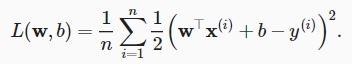
>>x是样本i的特征  
>>y是样本i的标签  
>>(w,b)是权重和偏置参数  


>任务：为了惩罚权重向量的大小，以某种方式在损失函数中添加 ∥w∥2，通过λ平衡这个新的额外惩罚的损失
>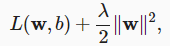

## 1.控制模型容量（复杂度）


>通过限制参数值的选择范围来控制模型容量（硬性限制）
>>目标损失函数：
>>·优化让损失函数最小化，加入限制让权重w小于一个值θ  
>>·通常不限制偏移b  
>>·小的θ意味着更小的正则项  

>通过超参数λ控制正则项的重要程度（柔性限制）
>>目标损失函数：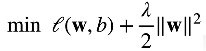
>>λ=0：无作用    
>>λ->∞, w*->0  
>>较小的λ值对应较少约束的w，而较大的λ值对w的约束更大


权重衰退：每次权重w更新前被λ缩小

---
---
---
# 二、代码

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## 1.生成数据
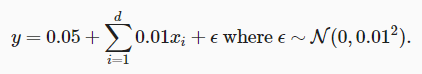
>偏差b = 0.05  
>权重w = 0.01  
>噪音方差为0.01正太分布

In [2]:
#训练集20个（训练数据小，容易过拟合），测试集100个，特征维度200，训练次数5
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5   
#权重w = 0.01， 偏差b = 0.05
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05   

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 2.初始化模型参数

定义一个函数来随机初始化我们的模型参数

In [3]:
#定义一个函数来随机初始化我们的模型参数

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 3.定义 L2 范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

## 4. 定义训练代码实现

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

## 5.忽略正则化直接训练 λ=0

训练误差有了减少，但测试误差没有减少。这意味着出现了严重的过拟合

w的L2范数是： 13.38011360168457


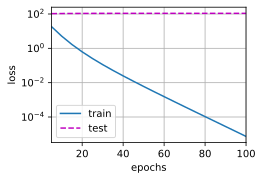

In [6]:
train(lambd=0)

## 6.使用权重衰减λ=3

训练误差增大，但测试误差减小。这正是我们期望从正则化中得到的效果。

w的L2范数是： 0.3483315408229828


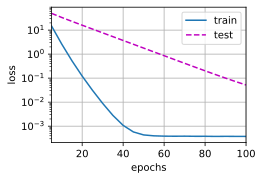

In [7]:
train(lambd=3)